# CGAN
_Conditional Generative Adversarial Network_

## Preview
___

## Drive Path

/content/drive/MyDrive/Colab Notebooks/Ex/Ex-16

## Index
___


1.   항목 추가

1.   항목 추가
2.   항목 추가


2.   항목 추가



## Set up

### Module
___

In [1]:
import os
import sys
import pickle
import random

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import tensorflow as tf

In [2]:
random_seed = 1234

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [26]:
%matplotlib inline

# plt.style.use('default')
plt.style.use('seaborn')

mpl.rcParams['figure.figsize'] = (4, 4)
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.labelleft'] = False
# mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({'figure.autolayout': True})

warnings.filterwarnings('ignore')

In [6]:
# this code is for not printing warning error info
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
import shutil

## Preface
___

# 출처
___

코드 참고  
_https://github.com/thisisiron/TF2-GAN_

# 진행
___

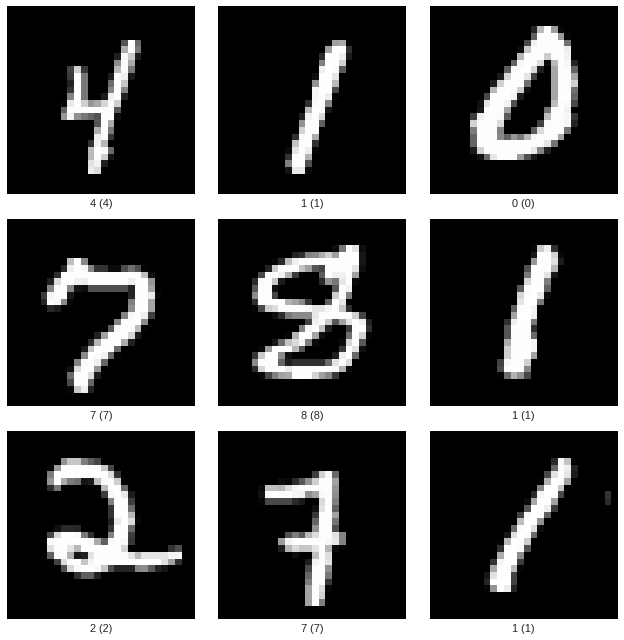

In [27]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [28]:
BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


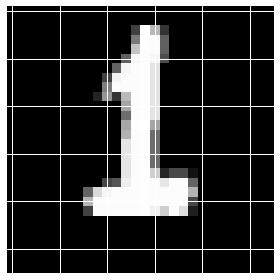

In [29]:
for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)
plt.show()

In [30]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

In [31]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

In [32]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

In [33]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

In [34]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

In [35]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

In [36]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [37]:
path = '/content/drive/MyDrive/Colab Notebooks/Ex/Ex-16/GAN'
to_path = 'GAN'

if not os.path.isdir(to_path):
  shutil.copytree(path, to_path)

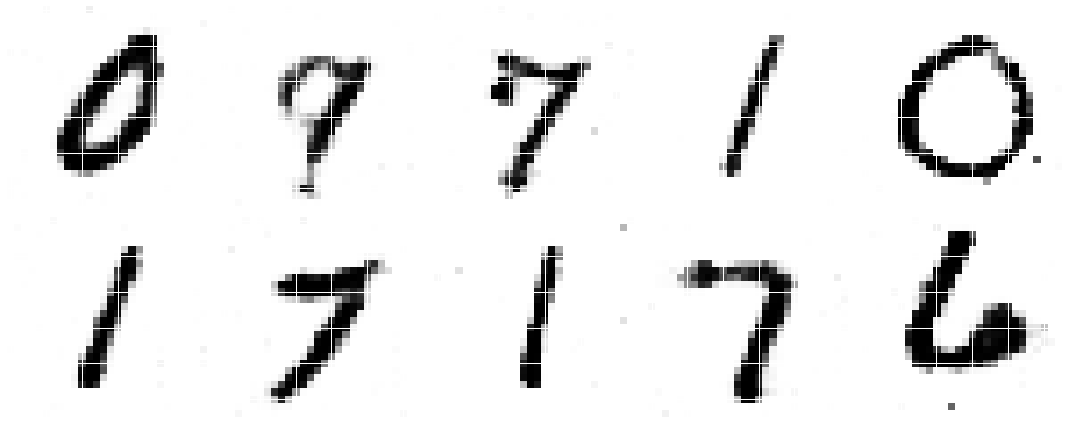

In [39]:
weight_path = 'GAN/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())
  
plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [40]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:2.1880569458007812, D:0.17147015035152435
[1/1 EPOCHS, 199 ITER] G:3.129582405090332, D:0.0696379616856575
[1/1 EPOCHS, 299 ITER] G:3.3819761276245117, D:0.0696132481098175
[1/1 EPOCHS, 399 ITER] G:4.146273136138916, D:0.028724614530801773


In [44]:
path = '/content/drive/MyDrive/Colab Notebooks/Ex/Ex-16/CGAN'
to_path = 'CGAN'

if not os.path.isdir(to_path):
  shutil.copytree(path, to_path)

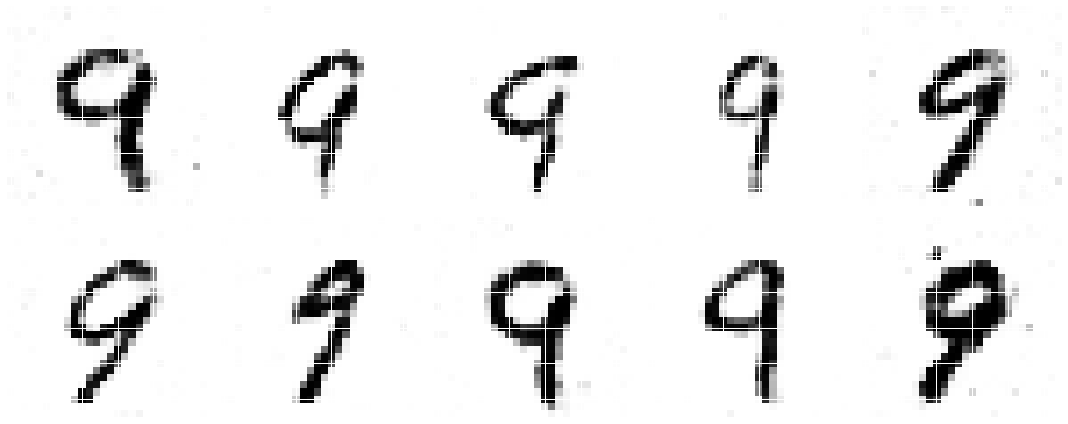

In [45]:
number = 9 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = 'CGAN/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# 회고